# But first, import!

In [108]:
# our core libraries
import math
import numpy as np
import pandas as pd
import neuropythy as ny
import nibabel as nib
import ipyvolume as ipv
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import StackingClassifier

import shap  # package used to calculate Shap values

# Next, load the data..

To `netmaps_df` we load "netmaps" which are subject-specific “parcellated connectomes” – for each subject, a nodes x nodes network matrix. See more [here](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP1200-DenseConnectome+PTN+Appendix-July2017.pdf).

To `behavioral_df` we load the data keys. See more [here](https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release). 

In [2]:
N = 15
netmaps_df = pd.read_csv('data/connectivityml/HCP_PTN1200/netmats/3T_HCP1200_MSMAll_d'+str(N)+'_ts2/netmats2.txt', delim_whitespace=True,header=None)
print("Network-matrices data shape:", netmaps_df.shape)
netmaps_df.head()

Network-matrices data shape: (1003, 225)


,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,0,-6.43160,2.9077,5.6367,-1.9108,-2.9030,-0.78089,1.6558,-0.46461,5.3488,...,3.4614,0.89082,-4.27550,5.1550,-6.4641,-5.1331,5.8573,-2.723100,6.1086,0
1,0,-4.09320,-4.8082,4.2359,1.2897,-6.0519,0.11149,-6.8054,-2.10540,2.7563,...,6.3430,0.35134,-0.67089,7.6578,-3.8168,-3.7186,1.4174,-2.052100,5.0104,0
2,0,-0.15331,-4.4759,11.8270,-4.2061,-6.5727,-1.61310,-10.2110,-1.28100,2.0158,...,2.4110,3.49980,-1.95180,2.4394,-9.2378,-3.5996,4.5837,-3.172500,4.0976,0
3,0,-0.87383,-6.8278,10.1640,-1.8393,-9.1321,-2.86400,-7.2182,1.55410,2.2322,...,-3.2454,0.34570,-1.92850,6.4472,-6.9826,-1.2231,6.6318,-0.667030,7.3691,0
4,0,-3.96500,2.5420,11.5050,-4.9034,-2.4797,3.18270,-4.2678,1.84570,5.9304,...,2.2238,7.66490,1.33870,8.1098,-1.4201,-1.3990,8.1015,0.014264,1.4994,0


In [3]:
behavioral_df = pd.read_csv('data/connectivityml/unrestricted_pkalra_7_26_2021_17_39_25.csv')
print("Behaviora data shape:", behavioral_df.shape)
behavioral_df.head()

Behaviora data shape: (1206, 582)


,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


We have netmaps for 1003 subjects so we will need to filter `behavioral_df` a little.

To `subjectsID_df` we load the ordered list of all subjects with complete rfMRI data (recon 1 + recon2) included in this PTN release

In [98]:
subjectsID_df = pd.read_csv('data/connectivityml/HCP_PTN1200/subjectIDs.txt',header=None,names=["Subject"])
print("Subjects ID data shape:", subjectsID_df.shape)
subjectsID_df.head()

Subjects ID data shape: (1003, 1)


,Subject
0,100206
1,100307
2,100408
3,100610
4,101006


We can see that this corresponds to the number of netmaps we have.

In [5]:
filter_behavioral_df = subjectsID_df.merge(behavioral_df, on='Subject', how='inner')

print("Filtered behaviora data shape:", filter_behavioral_df.shape)
filter_behavioral_df.head()

Filtered behaviora data shape: (1003, 582)


,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
2,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
3,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
4,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80


# Ok, now let's visualize what we have:

In [6]:
filter_behavioral_df.columns

Index(['Subject', 'Release', 'Acquisition', 'Gender', 'Age',
       '3T_Full_MR_Compl', 'T1_Count', 'T2_Count', '3T_RS-fMRI_Count',
       '3T_RS-fMRI_PctCompl',
       ...
       'Noise_Comp', 'Odor_Unadj', 'Odor_AgeAdj', 'PainIntens_RawScore',
       'PainInterf_Tscore', 'Taste_Unadj', 'Taste_AgeAdj', 'Mars_Log_Score',
       'Mars_Errs', 'Mars_Final'],
      dtype='object', length=582)

In [7]:
# X = np.zeros(shape=(netmaps_df.shape[0],N*N))
# for index,row in netmaps_df.iterrows():
#     X[index] = np.triu(row.values.reshape(N,N),1).flatten()
    
# X.shape

netmapsX_df = pd.DataFrame(data = netmaps_df, columns = range(N*N))
netmapsX_df = netmapsX_df.T.drop_duplicates(keep='first').T
netmapsX_df = netmapsX_df.T.drop_duplicates(keep='last').T

X = netmapsX_df

y_age shape: (1003,)
y_gender shape: (1003,)
y_MMSE_Score shape: (1003,)
y_PSQI_Score shape: (1003,)


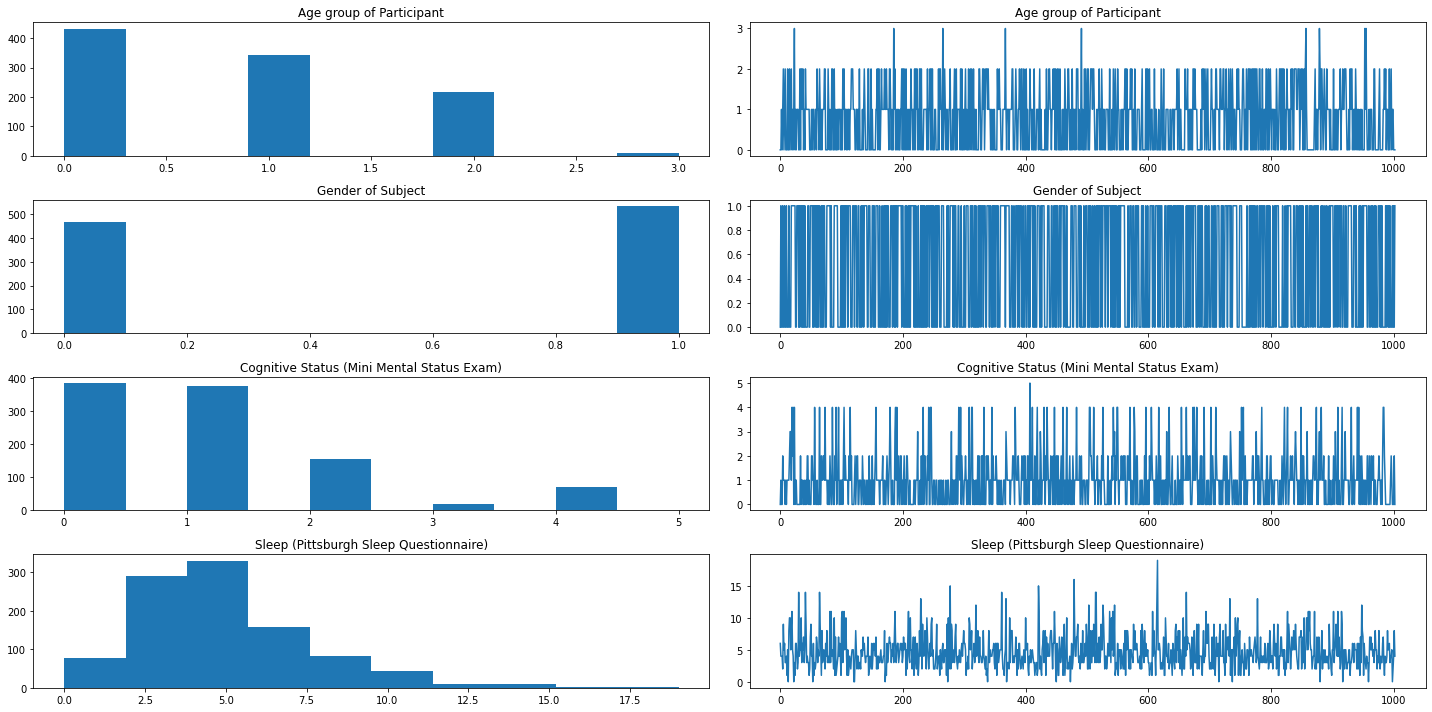

In [8]:
filter_behavioral_df['Age_i']=np.zeros(shape=(subjectsID_df.shape))
filter_behavioral_df.Age_i = pd.factorize(filter_behavioral_df.Age)[0] # Encode the object as an enumerated type or categorical variable.
y_age = filter_behavioral_df.Age_i # Age group of Participant, banded in five-year increments
print("y_age shape:", y_age.shape)

filter_behavioral_df['Gender_i']=np.zeros(shape=(subjectsID_df.shape))
filter_behavioral_df.Gender_i = pd.factorize(filter_behavioral_df.Gender)[0] # Encode the object as an enumerated type or categorical variable.
y_gender = filter_behavioral_df.Gender_i # Gender of Subject
print("y_gender shape:", y_gender.shape)

filter_behavioral_df['MMSE_Score_i']=np.zeros(shape=(subjectsID_df.shape))
filter_behavioral_df.MMSE_Score_i = pd.factorize(filter_behavioral_df.MMSE_Score)[0] # Encode the object as an enumerated type or categorical variable.
y_MMSE_Score = filter_behavioral_df.MMSE_Score_i # Cognitive Status (Mini Mental Status Exam)
print("y_MMSE_Score shape:", y_MMSE_Score.shape)

y_PSQI_Score = filter_behavioral_df.PSQI_Score # Sleep (Pittsburgh Sleep Questionnaire)
print("y_PSQI_Score shape:", y_PSQI_Score.dropna().shape)

fig, ax = plt.subplots(4,2,figsize=(20, 10))
ax[0][0].hist(y_age)
ax[0][0].set_title("Age group of Participant")
ax[1][0].hist(y_gender)
ax[1][0].set_title("Gender of Subject")
ax[2][0].hist(y_MMSE_Score)
ax[2][0].set_title("Cognitive Status (Mini Mental Status Exam)")
ax[3][0].hist(y_PSQI_Score)
ax[3][0].set_title("Sleep (Pittsburgh Sleep Questionnaire)")

ax[0][1].plot(y_age)
ax[0][1].set_title("Age group of Participant")
ax[1][1].plot(y_gender)
ax[1][1].set_title("Gender of Subject")
ax[2][1].plot(y_MMSE_Score)
ax[2][1].set_title("Cognitive Status (Mini Mental Status Exam)")
ax[3][1].plot(y_PSQI_Score)
ax[3][1].set_title("Sleep (Pittsburgh Sleep Questionnaire)")

fig.tight_layout()

In [9]:
filter_behavioral_df

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,Age_i,Gender_i,MMSE_Score_i
0,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,1.0,49.7,72.63,72.03,1.84,0.0,1.84,0,0,0
1,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,0.0,38.6,71.69,71.76,1.76,0.0,1.76,0,1,1
2,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,52.6,114.01,113.59,1.76,2.0,1.68,1,0,0
3,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,0.0,38.6,84.84,85.31,1.92,1.0,1.88,0,0,0
4,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,0.0,38.6,123.80,123.31,1.80,0.0,1.80,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,992673,S900,Q12,F,31-35,True,1,2,4,100.0,...,1.0,38.6,101.63,99.26,1.80,0.0,1.80,1,1,0
999,992774,Q2,Q02,M,31-35,True,2,2,4,100.0,...,4.0,50.1,107.17,103.55,1.76,0.0,1.76,1,0,0
1000,993675,S900,Q09,F,26-30,True,2,2,4,100.0,...,0.0,38.6,84.07,84.25,1.80,1.0,1.76,0,1,0
1001,994273,S500,Q06,M,26-30,True,1,1,4,100.0,...,7.0,63.8,110.65,109.73,1.80,1.0,1.76,0,0,2


# What would be the right estimator for our data?

See more [here](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

![image.png](attachment:25f7ff03-56a6-4c27-91d7-7a54e6cdfe78.png)

## Classification

### Linear Support Vector Classifier (SVC)

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC).

#### Age group of Participant, banded in five-year increments

Let's try to predict the age group of subjects in our dataset from our network-matrices data.

First we need to split the data into train and test - 

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_age, test_size=0.2,stratify=y_age)

Next, we'll use the LinearSVC, fit the model on train data and check the model accuracy score.

In [11]:
lsvc = svm.LinearSVC()

In [12]:
lsvc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = lsvc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

cv_scores = cross_val_score(lsvc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

Liblinear failed to converge, increase the number of iterations.


Test set score:  0.4577114427860697


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


CV average score: 0.45


Liblinear failed to converge, increase the number of iterations.


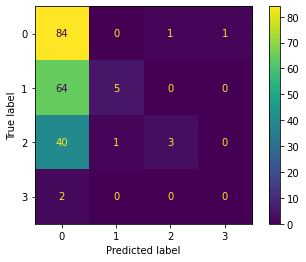

In [13]:
ypred = lsvc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(lsvc, xtest, ytest) # Plot Confusion Matrix.

<AxesSubplot:>

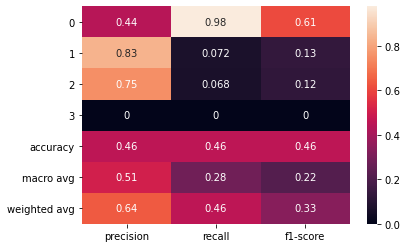

In [14]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

#### Gender of Subject

We will now repeat the steps above to try to predict the Gender of subjects in our dataset from our network-matrices data.

In [15]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_gender, test_size=0.2,stratify=y_gender)
lsvc = svm.LinearSVC()
lsvc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = lsvc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

cv_scores = cross_val_score(lsvc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


Test set score:  0.736318407960199
CV average score: 0.74


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


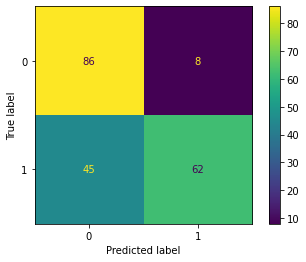

In [16]:
ypred = lsvc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(lsvc, xtest, ytest) # Plot Confusion Matrix.

<AxesSubplot:>

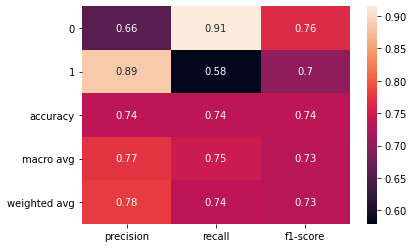

In [17]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

#### Cognitive Status (Mini Mental Status Exam)

and now again for Cognitive Status (Mini Mental Status Exam)

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)
lsvc = svm.LinearSVC()
lsvc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = lsvc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

cv_scores = cross_val_score(lsvc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

Liblinear failed to converge, increase the number of iterations.
The least populated class in y has only 1 members, which is less than n_splits=3.


Test set score:  0.417910447761194


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


CV average score: 0.29


Liblinear failed to converge, increase the number of iterations.


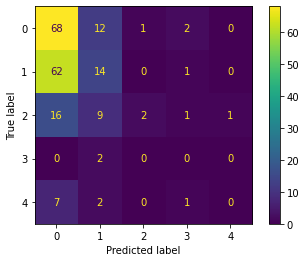

In [19]:
ypred = lsvc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(lsvc, xtest, ytest) # Plot Confusion Matrix.

<AxesSubplot:>

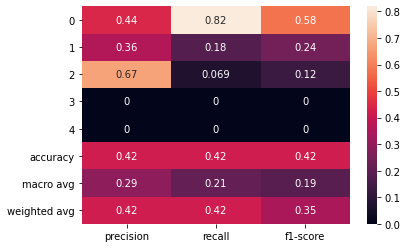

In [20]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

### Support Vector Classifier (SVC)

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC).

#### Age group of Participant, banded in five-year increments

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_age, test_size=0.2,stratify=y_age)
svc = svm.SVC()
svc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = svc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

cv_scores = cross_val_score(svc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

Test set score:  0.4079601990049751
CV average score: 0.47


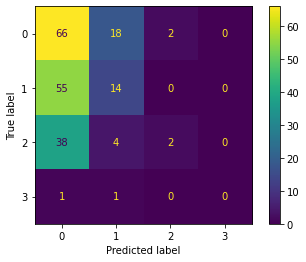

In [22]:
ypred = svc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(svc, xtest, ytest) # Plot Confusion Matrix.

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


<AxesSubplot:>

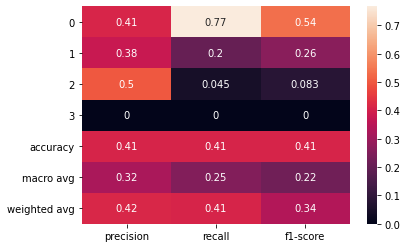

In [23]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

#### Gender of Subject

In [24]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_gender, test_size=0.2,stratify=y_gender)
svc = svm.SVC()
svc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = svc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

cv_scores = cross_val_score(svc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

Test set score:  0.8009950248756219
CV average score: 0.79


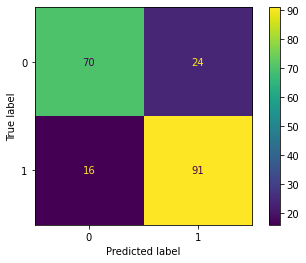

In [25]:
ypred = svc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(svc, xtest, ytest) # Plot Confusion Matrix.

<AxesSubplot:>

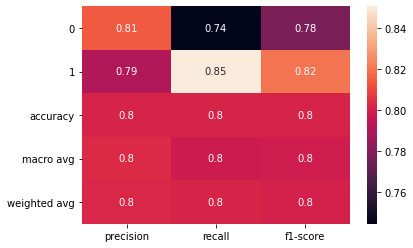

In [26]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

#### Cognitive Status (Mini Mental Status Exam)

and now again for Cognitive Status (Mini Mental Status Exam)

In [27]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)
svc = svm.SVC()
svc.fit(xtrain, ytrain) # Fit the model according to the given training data.
score = svc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

cv_scores = cross_val_score(svc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

Test set score:  0.4129353233830846
CV average score: 0.35


The least populated class in y has only 1 members, which is less than n_splits=3.


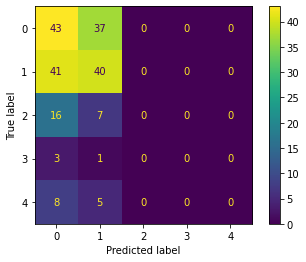

In [28]:
ypred = svc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(svc, xtest, ytest) # Plot Confusion Matrix.

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


<AxesSubplot:>

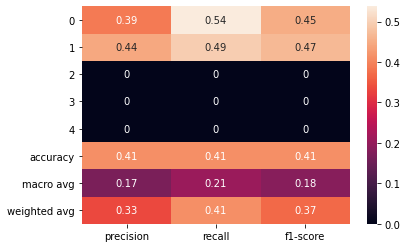

In [29]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

### KNeighborsClassifier

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).

#### Age group of Participant, banded in five-year increments

In [30]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_age, test_size=0.2,stratify=y_age)

In [31]:
knc = KNeighborsClassifier(n_neighbors = 4)
knc.fit(xtrain, ytrain)

score = knc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

cv_scores = cross_val_score(knc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

Test set score:  0.4427860696517413
CV average score: 0.42


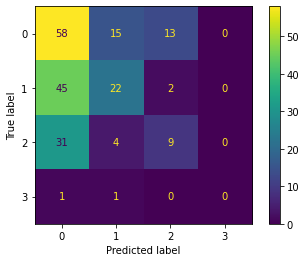

In [32]:
ypred = knc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(knc, xtest, ytest) # Plot Confusion Matrix.

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


<AxesSubplot:>

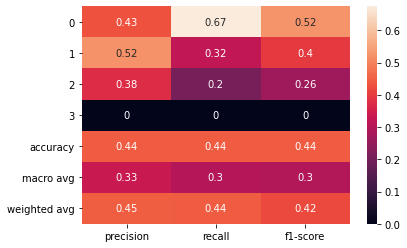

In [33]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

#### Gender of Subject

In [34]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_gender, test_size=0.2,stratify=y_gender)

In [35]:
knc = KNeighborsClassifier(n_neighbors = 4)
knc.fit(xtrain, ytrain)

score = knc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

cv_scores = cross_val_score(knc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

Test set score:  0.6318407960199005
CV average score: 0.65


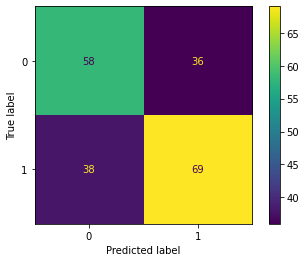

In [36]:
ypred = knc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(knc, xtest, ytest) # Plot Confusion Matrix.

<AxesSubplot:>

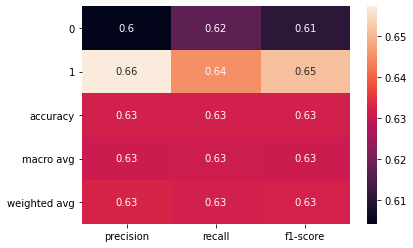

In [37]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

#### Cognitive Status (Mini Mental Status Exam)

In [38]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)

In [39]:
knc = KNeighborsClassifier(n_neighbors = 4)
knc.fit(xtrain, ytrain)

score = knc.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score)

cv_scores = cross_val_score(knc, xtrain, ytrain, cv=3)
print("CV average score: %.2f" % cv_scores.mean())

Test set score:  0.31343283582089554
CV average score: 0.33


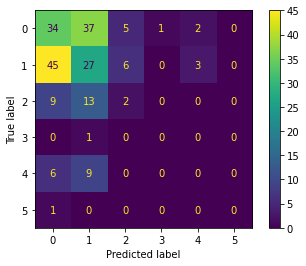

In [40]:
ypred = knc.predict(xtest) # Predict class labels for samples in X.
plot_confusion_matrix(knc, xtest, ytest) # Plot Confusion Matrix.

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


<AxesSubplot:>

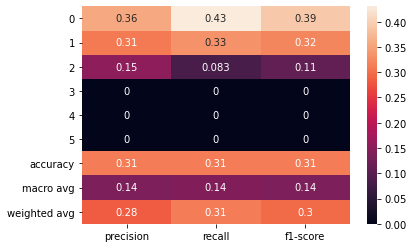

In [41]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report

## Regression

### Regression based on k-nearest neighbors

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor).

#### Sleep (Pittsburgh Sleep Questionnaire)

In [42]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_PSQI_Score, test_size=0.2)

In [43]:
for n_neighbors in range(2,6):
    print("n_neighbors = ", n_neighbors)
    kng = KNeighborsRegressor(n_neighbors = n_neighbors)
    kng.fit(xtrain, ytrain)

    score = kng.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
    print("Test set score: ", score) 
    
    cv_scores = cross_val_score(kng, xtest, ytest, cv=3)
    print("CV average score: %.2f" % cv_scores.mean())
    
    ypred = kng.predict(xtest) # Predict class labels for samples in X.
    mse = mean_squared_error(ytest, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse*(1/2.0)) 
    
    print("\n")

n_neighbors =  2
Test set score:  -0.5283925670390501
CV average score: -0.73
MSE:  11.317164179104477
RMSE:  5.6585820895522385


n_neighbors =  3
Test set score:  -0.23583839761460634
CV average score: -0.40
MSE:  9.150912106135987
RMSE:  4.5754560530679935


n_neighbors =  4
Test set score:  -0.18879176778515405
CV average score: -0.30
MSE:  8.802549751243781
RMSE:  4.4012748756218905


n_neighbors =  5
Test set score:  -0.1478649792414608
CV average score: -0.21
MSE:  8.499502487562188
RMSE:  4.249751243781094




### Epsilon-Support Vector Regression

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html).

#### Sleep (Pittsburgh Sleep Questionnaire)

In [44]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_PSQI_Score, test_size=0.2)

In [45]:
for n_neighbors in range(2,6):
    print("n_neighbors = ", n_neighbors)
    kng = KNeighborsRegressor(n_neighbors = n_neighbors)
    kng.fit(xtrain, ytrain)

    score = kng.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
    print("Test set score: ", score) 
    
    cv_scores = cross_val_score(kng, xtest, ytest, cv=3)
    print("CV average score: %.2f" % cv_scores.mean())
    
    ypred = kng.predict(xtest) # Predict class labels for samples in X.
    mse = mean_squared_error(ytest, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse*(1/2.0)) 
    
    print("\n")

n_neighbors =  2
Test set score:  -0.4775615918532454
CV average score: -0.64
MSE:  11.39179104477612
RMSE:  5.69589552238806


n_neighbors =  3
Test set score:  -0.3973479813967027
CV average score: -0.52
MSE:  10.773355444997236
RMSE:  5.386677722498618


n_neighbors =  4
Test set score:  -0.2475143345126265
CV average score: -0.37
MSE:  9.618159203980099
RMSE:  4.8090796019900495


n_neighbors =  5
Test set score:  -0.2534445849893736
CV average score: -0.30
MSE:  9.663880597014925
RMSE:  4.831940298507463




## Poor performance... Time for Random forests!

### RandomForestClassifier

#### Age group of Participant, banded in five-year increments

In [46]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_age, test_size=0.2,stratify=y_age)

In [47]:
rf = RandomForestClassifier(max_depth=N)

rf.fit(xtrain, ytrain)

# pd.Series(rf.feature_importances_, index=xtrain.columns).sort_values(ascending=False).head(10)

score = rf.score(xtest, ytest)
print("Test set score (R-squared):", score) 

ypred = rf.predict(xtest)

mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

Test set score (R-squared): 0.4626865671641791
MSE:  1.1393034825870647
RMSE:  0.5696517412935324


##### Sham Summary Plots

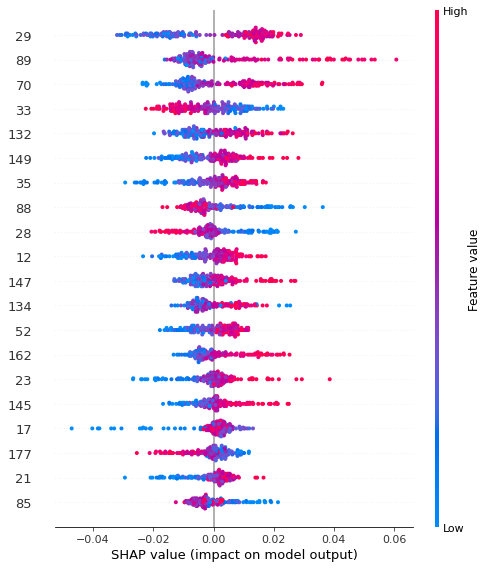

In [48]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of xtest rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(xtest)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], xtest)

#### Gender of Subject

In [49]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_gender, test_size=0.2,stratify=y_gender)

In [50]:
rf = RandomForestClassifier(max_depth=N)
rf.fit(xtrain, ytrain)
# pd.Series(rf.feature_importances_, index=xtrain.columns).sort_values(ascending=False).head(10)

score = rf.score(xtest, ytest)
print("Test set score (R-squared):", score) 

ypred = rf.predict(xtest)

mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

Test set score (R-squared): 0.7213930348258707
MSE:  0.27860696517412936
RMSE:  0.13930348258706468


##### Sham Summary Plots

See more [here](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values).

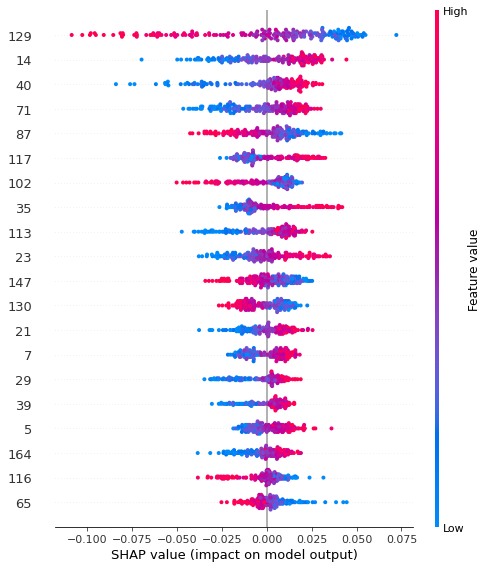

In [51]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of xtest rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(xtest)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], xtest)

#### Cognitive Status (Mini Mental Status Exam)

In [52]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_MMSE_Score, test_size=0.2)

In [53]:
rf = RandomForestClassifier(max_depth=N)
rf.fit(xtrain, ytrain)
# pd.Series(rf.feature_importances_, index=xtrain.columns).sort_values(ascending=False).head(10)

score = rf.score(xtest, ytest)
print("Test set score (R-squared):", score) 

ypred = rf.predict(xtest)

mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

Test set score (R-squared): 0.3482587064676617
MSE:  1.835820895522388
RMSE:  0.917910447761194


##### Sham Summary Plots

See more [here](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values).

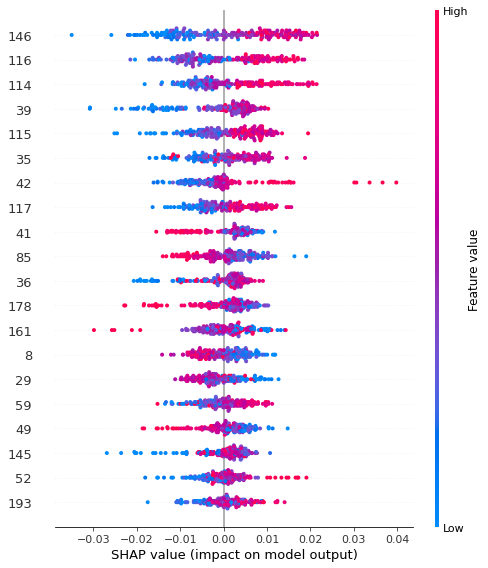

In [54]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of xtest rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(xtest)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], xtest)

#### Sleep (Pittsburgh Sleep Questionnaire)

In [55]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_PSQI_Score, test_size=0.2)

In [56]:
rf = RandomForestClassifier(max_depth=N)
rf.fit(xtrain, ytrain)
# pd.Series(rf.feature_importances_, index=xtrain.columns).sort_values(ascending=False).head(10)

score = rf.score(xtest, ytest)
print("Test set score (R-squared):", score) 

ypred = rf.predict(xtest)

mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

Test set score (R-squared): 0.1791044776119403
MSE:  10.537313432835822
RMSE:  5.268656716417911


##### Sham Summary Plots

See more [here](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values).

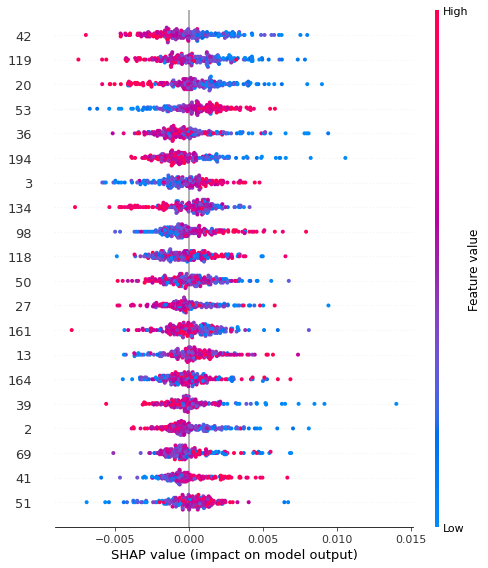

In [57]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of xtest rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(xtest)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], xtest)

# Visualization of the results

Predicting the gender of subjects in our dataset from our network-matrices data has gave us the best results...

In [50]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_gender, test_size=0.2,stratify=y_gender)

rf = RandomForestClassifier(max_depth=N)
rf.fit(xtrain, ytrain)
# pd.Series(rf.feature_importances_, index=xtrain.columns).sort_values(ascending=False).head(10)

score = rf.score(xtest, ytest)
print("Test set score (R-squared):", score) 

ypred = rf.predict(xtest)

mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

Test set score (R-squared): 0.7213930348258707
MSE:  0.27860696517412936
RMSE:  0.13930348258706468


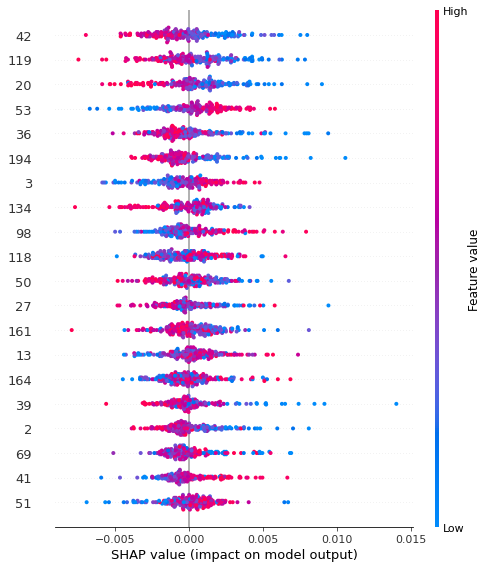

In [109]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of xtest rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(xtest)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], xtest)

We will look at SHAP values for a single row of the dataset (we arbitrarily chose row 5). For context, we'll look at the raw predictions before looking at the SHAP values.



In [111]:
row_to_show = random.randint(0,len(subjectsID_df.Subject))
data_for_prediction = xtest.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

rf.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [113]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [115]:
# You need to configure neuropythy so that it knows what your
# HCP AWS S3 access key and secret are:
ny.config['hcp_credentials'] = (key, secret)
ny.config['hcp_auto_download'] = True
# Auto-download will work without these commands, but they let
# neuropythy find the cached files next time you start it up
# (without this, everything you download will be lost when
# your python process quits).
ny.config['hcp_auto_path'] = '~/hcp_data'

# There are also instructions in the neuropythy README.md file
# (see https://github.com/noahbenson/neuropythy/) on how to
# set this up in the ~/.npythyrc configuration file. Additional
# info is also in the neuropythy wiki under the configuration
# heading.

In [116]:
# Get a sample HCP subject:
sub = ny.hcp_subject(subjectsID_df.Subject[row_to_show])
# (This yields a neuropythy Subject object)
sub

Subject(<101915>, <'s3://hcp-openaccess/HCP_1200/101915'>)

In [117]:
# sub.lh and sub.rh are the "native" (FreeSurfer) hemispheres;
# sub.hemis['lh_LR32k'] and sub.hemis['rh_LR32k'] are the
# HCP subject-aligned fs_LR hemispheres (with 32k resolution).
lh_hemi_native = sub.lh
rh_hemi_native = sub.rh
lh_hemi_LR32k = sub.hemis['lh_LR32k']
rh_hemi_LR32k = sub.hemis['rh_LR32k']

In [118]:
# Load the CIFTI file:
cii_filename = '~/data/connectivityml/HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d'+str(N)+'.ica/melodic_IC.dscalar.nii'
cii_obj = ny.load(cii_filename)

# Split the CIFTI object into hemisphere/subvoxel data:
(lh_data, rh_data, subvox_data) = ny.hcp.cifti_split(cii_obj)

# These data should be (data-points x vertices)
lh_data.shape

(15, 32492)

In [120]:
# The 32492 size indicates this is a 32k LR hemisphere:
lh_hemi = sub.hemis['lh_LR32k']
rh_hemi = sub.hemis['rh_LR32k']

# We can make an ipyvolume figure to plot both hemispheres on:
fig = ipv.figure()
# Then plot each hemisphere using whichever ICA component we
# want to visualize:
ica_num = 0
ny.cortex_plot(lh_hemi, surface='inflated', # very_inflated
               color=lh_data[ica_num], cmap='hot', figure=fig)
ny.cortex_plot(rh_hemi, surface='inflated',
               color=rh_data[ica_num], cmap='hot', figure=fig)

neuropythy: NOTE: due to a bug in ipyvolume, camera views cannot currently be set by neuropythy; however, if you click the reset (home) button in the upper-left corner of the figure, the requested view will be fixed.


Figure(camera=PerspectiveCamera(fov=0.644570721372708, position=(0.0, -100.0, 0.0), projectionMatrix=(1.0, 0.0…